In [1]:
import pprint, sys, copy, datetime, functools, pickle, random, pickle, gc, math, random


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt 
import seaborn as sns
    
import lightgbm as lgb
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

%matplotlib inline

In [6]:
def reduce_mem_usage(df, verbose=True):    
    '''
    INPUT:
    df - a pandas dataframe containing raw data
    verbose - a Booler to determine print the result of storage decrease or not
    
    OUTPUT:
    
    This function will suppress INPUT.df by changing data type for storage
    '''    
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose: print("Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
DATA_ROOT_PATH = "data/"

data_train_path = DATA_ROOT_PATH + "train/train.csv"
data_test_path = DATA_ROOT_PATH + "test/test.csv"
data_info_path = DATA_ROOT_PATH  + "Data_Dictionary.xlsx"
data_merchants_path = DATA_ROOT_PATH + "data_raw/merchants.csv"
data_his_trans_path = DATA_ROOT_PATH + "data_raw/historical_transactions.csv"
data_new_trans_path = DATA_ROOT_PATH + "data_raw/new_merchant_transactions.csv"

data_train = pd.read_csv(data_train_path)
data_test = pd.read_csv(data_test_path)
data_info = pd.read_excel(data_info_path, sheetname=[0, 1, 2, 3], header=None)
data_merchants = pd.read_csv(data_merchants_path)
data_new_merchant_transactions = pd.read_csv(data_new_trans_path)

data_historical_transactions_reader = pd.read_csv(data_his_trans_path, chunksize=6000000)
data_historical_transactions_list = []
indent = 1

for each_chunk in data_historical_transactions_reader:
    print("[Output] expected to be end in 5 runs, this is {} run...".format(indent))
    each_chunk = reduce_mem_usage(each_chunk)
    data_historical_transactions_list.append(each_chunk)
    indent += 1
    gc.collect()
sys._clear_type_cache()
data_historical_transactions = pd.concat(data_historical_transactions_list, ignore_index=True)

del data_historical_transactions_list
del each_chunk

[Output] expected to be end in 5 runs, this is 1 run...
Mem. usage decreased to 360.49 Mb (43.7% reduction)
[Output] expected to be end in 5 runs, this is 2 run...
Mem. usage decreased to 360.49 Mb (43.7% reduction)
[Output] expected to be end in 5 runs, this is 3 run...
Mem. usage decreased to 360.49 Mb (43.7% reduction)
[Output] expected to be end in 5 runs, this is 4 run...
Mem. usage decreased to 360.49 Mb (43.7% reduction)
[Output] expected to be end in 5 runs, this is 5 run...
Mem. usage decreased to 307.16 Mb (43.7% reduction)


### Business understanding

#### Outline the questions you will answer

**1.** What scale and what kind of data are necessary for customer loyalty prediction model? 

**2.** In which way the application of customer loyalty predicition model would impact different business units?

**3.** How to evaluate the influence of deploying customer loyalty prediction model? Is modeling target really convincible?

**4.** How to balance model prediction and customer review?

**5.** What could customers expect to be benefited from this customer loyalty prediction model?


#### Check out why these questions are relevant and important

**1.** This will provide proper evaluation of how many sources company need to invest for the deploy of customer loyalty prediction model.

**2.** By diving into this, necessary changes would to be revealed which will help company work better. 

**3.** It helps the application of customer loyalty prediction model controllable and scalable.

**4.** Generally any great model could never be 100% accuracy in reality. Thus, reviews from customers are valuable for model improvement which is the part of the business cycle.

**5.** Customer only buy what they think is valuable. Declare the benefits will bring more customers which means more transactions and more data used for model feeding and evaluation. 

#### Answers

* Question 1: What scale and what kind of data are necessary for customer loyalty prediction model? 

In [27]:
print("[Output] The size and memory usage of two card feature data: ")
print("[1] Training data:")
data_train.info(verbose=False, memory_usage="deep")
print("[2] Testing data:")
data_test.info(verbose=False, memory_usage="deep")
print("\n")

print("[Output] The size and memory usage of two transaction data: ")
print("[1] New merchant transaction")
data_new_merchant_transactions.info(verbose=False, memory_usage="deep")

# Note 2019/2/12: excute the following code raise MemoryError in my computer
# data_historical_transactions.info(verbose=False, memory_usage=True)

print("[2] Historical merchant transaction")
print(data_historical_transactions.shape)
print("\n")

print("[Output] The size and memory usage of merchant data: ")
data_merchants.info(verbose=False, memory_usage="deep")

[Output] The size and memory usage of two card feature data: 
[1] Training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Columns: 6 entries, first_active_month to target
dtypes: float64(1), int64(3), object(2)
memory usage: 32.4 MB
[2] Testing data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Columns: 5 entries, first_active_month to feature_3
dtypes: int64(3), object(2)
memory usage: 18.9 MB


[Output] The size and memory usage of two transaction data: 
[1] New merchant transaction
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Columns: 14 entries, authorized_flag to subsector_id
dtypes: float64(2), int64(6), object(6)
memory usage: 899.5 MB
[2] Historical merchant transaction
(29112361, 14)


[Output] The size and memory usage of merchant data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Columns: 22 entries, merchant_id to category_2
dtypes: floa

**Answer 1.** As it is shown above, all needed data could be divide in three parts: card feature data,  transaction data and merchant data. Card feature data and merchant data both are relatively small than transaction data, which the later is nearly 30 millon, with memry usage more than 8 GB in total in this competition.

* Question 2: In which way the application of customer loyalty predicition model would impact different business units?

**Answer 2.** If customer loyalty prediction model are applied, finance part may need to expand or reconstruct exsited database to record more features as well as missing values; sales part need to use the conclusion of model for decision and collect customer review; technology part is supposed to assure model stablity and improve model using or contructing new features from finance part and reviews from sales part. This process would be visualized by [a business cycle]().

* Question 3: How to evaluate the influence of deploying customer loyalty prediction model? Is modeling target really convincible?

In [46]:
def check_target_distribution(data_path, df, col):
    '''
    INPUT:
    data_path -  a string showing the store path of INPUT.data 
    df -  a pandas dataframe containing raw data
    col -  a string indicating the column name of modeling target
    
    OUTPUT:
    
    This function will check the INPUT.col distribution of INPUT.data
    '''       
    name_file = data_path.split("/")[-1]
    name_var = "data_" + name_file[:-4]    
    
    print("[Input] File Name: {}, distribution visualization for VARIABLE \"{}\"".format(name_file, name_var))
    
    print("[Output] Data type of column feat named %s is %s" %(col, df[col].dtypes))
    print("\n")
    
    print("[Output] The distribution of column feat named %s: " %(col))
    count = df[col].value_counts()
    df[col].hist()
    # plt.plot(list(count.index), count.values, "o");
    plt.xlabel("The value of column feat named %s" %col)
    plt.ylabel("Count number")
    plt.show()

[Input] File Name: train.csv, distribution visualization for VARIABLE "data_train"
[Output] Data type of column feat named target is float64


[Output] The distribution of column feat named target: 


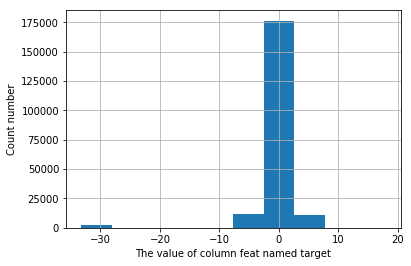

In [47]:
check_target_distribution(data_train_path, data_train, "target")

**Answer 3.** Take a look at the modeling target data above, it is stored in numberical data type which means serveral loss function like MSE could be used for evaluation. By checking its ditribution, there are outliers aound -30 found in modeling target which means not all target data is convincible.

* Question 4: How to balance model prediction and customer review?

In [30]:
# Note 2019/2/12: generate fake review data, choice Bool instead of [0, 1] providing concise meaning for other staff, 
#   however convert from categorical to numberical is necessary when training model with this feature

target_review_fake = [random.choice([False, True]) for indent in range(data_train.shape[0])]

data_train["target_review_fake"] = target_review_fake
data_train["target_review_fake"].value_counts()

True     101159
False    100758
Name: target_review_fake, dtype: int64

**Answer 4.** For simplicity, adjust modeling target by adding new indicator feature could be a solution. The example is shown above and using converted numberical "target_review_target" when training model. What's more, i think algorithm behind GAN may be a good choice.

* Question 5: What could customers expect to be benefited from this customer loyalty prediction model?

**Answer 5.** Because to the company is aimed at offerring promotions or discounts to cardholders, this customer loyalty prediction model could guarantee the quality of company services. Thus, the more convincible these services have, the more pleasure consumer experience customers have.

### Data understanding

#### check statistical characters like mean and std deviations

In [7]:
def check_basically(data_path, data):
    '''
    INPUT:
    data_path - expected to be a string showing the store path of INPUT.data 
    data - expected to be a pandas dataframe containing raw data
    
    OUTPUT:
    
    This function will check the statistical characters of INPUT.data
    '''
    type_dict = {}
    name_file = data_path.split("/")[-1]
    name_var = "data_" + name_file[:-4]
    
    print("[Input] File Name: {}, basic checking for VARIABLE \"{}\""
          .format(name_file, name_var))
    print("[Output] The useful statisitical characters of whole data: ")
    pprint.pprint(data.describe())
    print("\n")
    print("[Output] The fifth rows of raw data: ")
    pprint.pprint(data.head())
    print("\n")
    print("[Output] The shape of file data: ")
    pprint.pprint(data.shape)
    print("\n")
    print("---End Line---")
    print("\n")

In [8]:
check_basically(data_train_path, data_train)
check_basically(data_test_path, data_test)

[Input] File Name: train.csv, basic checking for VARIABLE "data_train"
[Output] The useful statisitical characters of whole data: 
           feature_1      feature_2      feature_3         target
count  201917.000000  201917.000000  201917.000000  201917.000000
mean        3.105311       1.745410       0.565569            NaN
std         1.186160       0.751362       0.495683       0.000000
min         1.000000       1.000000       0.000000     -33.218750
25%         2.000000       1.000000       0.000000      -0.883301
50%         3.000000       2.000000       1.000000      -0.023438
75%         4.000000       2.000000       1.000000       0.765625
max         5.000000       3.000000       1.000000      17.968750


[Output] The fifth rows of raw data: 
  first_active_month          card_id  feature_1  feature_2  feature_3  \
0            2017-06  C_ID_92a2005557          5          2          1   
1            2017-01  C_ID_3d0044924f          4          1          0   
2            

####  check completion

In [5]:
def check_completion(data_path, df):
    '''
    INPUT:
    data_path -  a string showing the store path of INPUT.data 
    df -  a pandas dataframe containing raw data
    
    OUTPUT:
    
    This function will check the completion of INPUT.data
    '''    
    name_file = data_path.split("/")[-1]
    name_var = "data_" + name_file[:-4]

    print("[Input] File Name: {}, completion checking for VARIABLE \"{}\""
          .format(name_file, name_var))
    collector_df = pd.DataFrame(
        df.isnull().sum().values, columns=["feature"], 
        index=np.arange(len(df.columns))).set_index(df.columns).sort_values(by=['feature'], 
        ascending=False)
    print("[Output] The vacancy numbers of whole data: ")
    pprint.pprint(collector_df)
    print("[Output] The vacancy proportion of whole data: ")
    pprint.pprint(collector_df/df.shape[0]*100)    
    print("\n")
    print("---End Line---")
    print("\n")

In [6]:
check_completion(data_train_path, data_train)
check_completion(data_test_path, data_test)

[Input] File Name: train.csv, completion checking for VARIABLE "data_train"
[Output] The vacancy numbers of whole data: 
                    feature
first_active_month        0
card_id                   0
feature_1                 0
feature_2                 0
feature_3                 0
target                    0


---End Line---


[Input] File Name: test.csv, completion checking for VARIABLE "data_test"
[Output] The vacancy numbers of whole data: 
                    feature
first_active_month        1
card_id                   0
feature_1                 0
feature_2                 0
feature_3                 0


---End Line---




####  check repeatablity

In [11]:
def chech_repeatablity(df, col_groupby):
    '''
    INPUT:
    df - expected to be a pandas dataframe containing raw data
    col_groupby -  expected to be a string as the indicator of reindexing
    
    OUTPUT:
    is_repeatablity - expected to be a Booler value indicating the repeatablity of INPUT.df
    
    This function will check the repeatablity of INPUT.df
    '''
    # print(df.shape, df.groupby(col_groupby).mean().shape)
    is_repeatablity = not(df.shape[0] == df.groupby(col_groupby).mean().shape[0])
    
    return is_repeatablity

In [12]:
print("[Output]The repeatablity checking result for training data is {}".format(chech_repeatablity(data_train, "card_id")))
print("[Output]The repeatablity checking result for testing data is {}".format(chech_repeatablity(data_test, "card_id")))

[Output]The repeatablity checking result for training data is False
[Output]The repeatablity checking result for testing data is False


####  check column descriptions

In [13]:
def collect_datatype(df):
    '''
    INPUT:
    df -  a pandas dataframe cotaining raw data
    
    OUTPUT:
    data_type_dict -  a dictionary containg all column data types of INPUT.data
    
    This function will find out every data type of all column data 
            (assumption: all data in one column share same data type)
    '''
    data_type_dict = {
        each_column: str(df[each_column].dtypes) for each_column in df.columns}
    
    return data_type_dict

In [14]:
def collect_datadescription(df, flag_df):
    '''
    INPUT:
    df -  a pandas dataframe containing raw data
    flag_df -  a string indicating the meaning of INPUT.df
    
    OUTPUT:
    data_types_df -  a pandas dataframe containing column data type and description of INPUT.df
    
    This function will obtain column data type and description of INPUT.df
    '''
    data_types_dict = collect_datatype(df)
    data_types_dict_new = {
        each_col: [data_types_dict[each_col]] for each_col in data_types_dict}
    
    if "train" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(
                data_info[0][data_info[0][0] == each_col][1].values[0])
    if "his" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(
                data_info[1][data_info[1][0] == each_col][1].values[0])
    if "new" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(
                data_info[2][data_info[2][0] == each_col][1].values[0])
    if "merchant" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(
                data_info[3][data_info[3][0] == each_col][1].values[0])
   
    data_types_df = pd.DataFrame(data_types_dict_new, index=[0, 1])
    
    return data_types_df

In [15]:
data_train_des = collect_datadescription(data_train, "train")
data_train_des

,card_id,feature_1,feature_2,feature_3,first_active_month,target
0,object,int8,int8,int8,object,float16
1,Unique card identifier,Anonymized card categorical feature,Anonymized card categorical feature,Anonymized card categorical feature,"'YYYY-MM', month of first purchase",Loyalty numerical score calculated 2 months af...


####  linear relationship checking

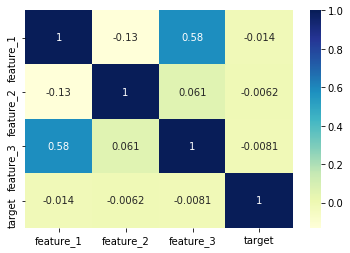

In [18]:
sns.heatmap(data_train.corr(), annot = True, cmap = "YlGnBu");

#### conclusion and disscussion

Questions

**1.** Provide the number of rows and columns in this datasets, find each data type of this datasets columns

**2.** Provide the missing value distribution of this datasets, find out which columns have the most missing values and provide a set of column names that have more than 75% if their values missing if any

**3.** Check duplication of this datasets along with "card_id" column feat

**4.** Collect description of each column of this datasets if provided

**5.** Provide column feat "target" value distribution, find out if any outlier exist

**6.** Check out the relationship between column feat "target" and rest column feats of training dataset

Answers

**1.** Seeing the result of assignment to function "check_basically" in the notebook, training dataset has 201917 rows and 6 columns, testing dataset has 123623 rows and 5 columns. Furthermore, among training dataset, and testing dataset, apart from two categorical column feat "first_active_month", "card_id", the rest column feats are all stored in numberical type.

**2.** Seeing the result of assignment to function "check_completion" in the notebook, training dataset has no vacancy while testing dataset has less than 0.1% vacancy at column feat "first_active_month". Thus there is no vacancy with its proportion larger than 75%.

**3.** Seeing the result of assignment to function "chech_repeatablity" in the notebook, there is no repeatablity in two datasets.

**4.** Seeing the result of assignment to function "collect_datadescription" in the notebook.

**5.** Seeing the result of assignment to function "check_target_distribution" in the notebook, meanwhile there is 2207 outliers found

**6.** Seeing the result in "linear relationship checking" part in the notebook, it seems that no linear relationship exists. 

### Data preparation

####   deal with missing values

Here i fill the missing value because there is only 1 missing value in testing dataset found in the section "check completion" above, which means filling would not break the raw data. 

In [8]:
data_test.fillna(method="ffill", inplace=True)

In [20]:
data_test.isnull().sum()  # check filling result

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

####  deal with outliers

As it is shown in the answer to the business question 3, the distrubution of modeling target do reveal outliers. Create a new column feat here will help model consider this information and learn better from data.

In [9]:
data_train["Outlier"] = 0
data_train.loc[data_train["target"] < -30, "Outlier"] = 1
data_train.loc[data_train["target"] == 0, "Outlier"] = 1

####  deal with mixed data

Thoung the raw date data could not be used, there are more information left in these time series which is revealed by many kagglers. Extraction from these date data would help model find more accurate relevance between modeling target and other dataset.

In [11]:
month_dict = \
        {1:"January", 
         2:"February", 
         3:"March", 
         4:"April", 
         5:"May", 
         6:"June", 
         7:"July", 
         8:"August", 
         9:"September", 
         10:"October", 
         11:"November", 
         12:"December"}


def apply_extraction2datedata(df, df_flag):
    '''
    INPUT:
    df - expected to be a pandas dataframe containing raw data
    df_flag - expected to be a string expected to be a string indicating the meaning of INPUT.df
    
    OUTPUT:
    df - expected to be a pandas dataframe containing expanded data after extraction
    
    This function will extract numberical data from date data in INPUT.df
    '''  
    df["first_active_month"] = pd.to_datetime(df["first_active_month"])
    df["first_active_month_dayofweek"] = df["first_active_month"].dt.dayofweek
    df["first_active_month_weekofyear"] = df["first_active_month"].dt.weekofyear
    df["first_active_month_month"] = df["first_active_month"].dt.month
    df["first_active_month_monthsession"] = \
            df["first_active_month_month"].map(month_dict)
    df["first_active_month_elapsed_time_today"] = (datetime.datetime.today() 
                                                      - df["first_active_month"]).dt.days
    df["first_active_month_elapsed_time_specific"] = (datetime.date(2018, 2, 1) 
                                                      - df['first_active_month'].dt.date).dt.days
    df.drop(["first_active_month"], axis=1, inplace=True)
        
    gc.collect()
    sys._clear_type_cache()
    
    return df

In [12]:
data_train = apply_extraction2datedata(data_train, "train")
data_test = apply_extraction2datedata(data_test, "test")

* deal with categorical data

Among the extraction of some meaningful column feats from date data, new categorical data are created such as "first_active_month_monthsession" and "card_id". 

By creating dummies for "first_active_month_monthsession", the advantage is you could easily draw conclusion of which frist active month is most relative to modeling target referring to the column feat importance figure shown in section "analysis of feature importance". The disadvantage it might bring is a large amount of sparsity which may leads failure for some models. Fortunately, learned from futher study, the model choosed here is strong enough to deal with it. That is the reason.

By dropping "card_id", the advantage is you will obtain model-trainable data. The disavantage is a possible missing of information. Taking the meaning of "card_id" into consideration, "card_id" is mainly created for distinguishment between each piece of data and no useful information is extracted from it alone yet. Thus i think it is safe to drop it.

In [13]:
def create_dummy(df, col_categ, dummy_na=False):
    '''
    INPUT:
    df -  a pandas dataframe with categorical variables you want to dummy
    col_categ -  a list containing strings that are associated with names of 
                          the categorical columns
    dummy_na -  a Bool holding whether you want to dummy NA vals of 
                             categorical columns or not
    
    OUTPUT:
    df -  a new pandas dataframe after transforming specific categorical column feat in 
            INPUT.col_categ to numbercial column feat
    
    This function will create dummy data and dummy columns from INPUT.df
    '''
    for col in  col_categ:
        try:
            df = pd.concat(
                [df.drop(col, axis=1), 
                        pd.get_dummies(df[col], prefix=col, prefix_sep='_', dummy_na=dummy_na)], 
                axis=1)
        except:
            continue
            
    return df

In [14]:
data_train = create_dummy(data_train, ["first_active_month_monthsession"])
data_test = create_dummy(data_test, ["first_active_month_monthsession"])

In [15]:
data_train.drop(["card_id"], axis=1, inplace=True)
data_test.drop(["card_id"], axis=1, inplace=True)

### Data modeling

In [16]:
labels = data_train["target"]
del data_train["target"]

In [17]:
import logging


def create_logger():
    '''
    This fuction will create a logger for recording training details
    '''
    FORMAT = '[%(levelname)s]%(asctime)s:%(name)s:%(message)s'
    logging.basicConfig(format=FORMAT)
    logger = logging.getLogger('main')
    logger.setLevel(logging.DEBUG)
    
    return logger

logger = create_logger()

In [18]:
# Note 2019/2/12: set parameters for model, refer to the default value listed in github(https://github.com/Microsoft/LightGBM)

param = {'num_leaves': 51,
         'min_data_in_leaf': 35, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.008,
         "boosting": "gbdt",
         "feature_fraction": 0.85,
         "bagging_freq": 1,
         "bagging_fraction": 0.82,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.11,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 2019}

In [19]:
train_columns = list(data_train.columns)
train_columns.remove("Outlier")

In [20]:
test_columns = train_columns

In [21]:
categorical_feats = ['feature_2', 'feature_3']

folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=2019)
oof = np.zeros(len(data_train))
predictions = np.zeros(len(data_test))
feature_importance_df = pd.DataFrame()

logger.info('Start running model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(data_train, data_train["Outlier"].values)):
    strLog = "fold {}".format(fold_)
    print(strLog) 
    trn_data = lgb.Dataset(data_train.iloc[trn_idx][train_columns], 
                           label=labels.iloc[trn_idx]) #, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(data_train.iloc[val_idx][train_columns], 
                           label=labels.iloc[val_idx]) #, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, 
                    trn_data, 
                    num_round, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=200, 
                    early_stopping_rounds = 150)
    oof[val_idx] = clf.predict(data_train.iloc[val_idx][train_columns], 
                               num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    gc.collect()
    sys._clear_type_cache()

    predictions += clf.predict(data_test[test_columns], 
                               num_iteration=clf.best_iteration) / folds.n_splits
    logger.info(strLog)
    
strRMSE = np.sqrt(mean_squared_error(oof, labels))
print("CV score is : %8.5f" %(strRMSE))

[INFO]2019-02-10 17:04:20,475:main:Start running model


fold 0
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.83481	valid_1's rmse: 3.86355
[400]	training's rmse: 3.83329	valid_1's rmse: 3.86368
Early stopping, best iteration is:
[299]	training's rmse: 3.83379	valid_1's rmse: 3.86348


[INFO]2019-02-10 17:04:26,435:main:fold 0


fold 1
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.85003	valid_1's rmse: 3.73925
Early stopping, best iteration is:
[154]	training's rmse: 3.851	valid_1's rmse: 3.73901


[INFO]2019-02-10 17:04:30,245:main:fold 1


fold 2
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.82357	valid_1's rmse: 3.95186
Early stopping, best iteration is:
[157]	training's rmse: 3.82444	valid_1's rmse: 3.95174


[INFO]2019-02-10 17:04:33,735:main:fold 2


fold 3
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.8318	valid_1's rmse: 3.88655
Early stopping, best iteration is:
[168]	training's rmse: 3.83241	valid_1's rmse: 3.88646


[INFO]2019-02-10 17:04:37,648:main:fold 3


fold 4
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.85652	valid_1's rmse: 3.68614
Early stopping, best iteration is:
[204]	training's rmse: 3.85646	valid_1's rmse: 3.68612


[INFO]2019-02-10 17:04:42,761:main:fold 4


fold 5
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.84047	valid_1's rmse: 3.81871
Early stopping, best iteration is:
[214]	training's rmse: 3.84027	valid_1's rmse: 3.81866


[INFO]2019-02-10 17:04:46,844:main:fold 5


fold 6
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.83432	valid_1's rmse: 3.8654
Early stopping, best iteration is:
[172]	training's rmse: 3.83487	valid_1's rmse: 3.86531


[INFO]2019-02-10 17:04:50,777:main:fold 6


fold 7
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.83244	valid_1's rmse: 3.88177
Early stopping, best iteration is:
[195]	training's rmse: 3.83252	valid_1's rmse: 3.88175


[INFO]2019-02-10 17:04:54,642:main:fold 7


fold 8
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.83216	valid_1's rmse: 3.88449
Early stopping, best iteration is:
[214]	training's rmse: 3.83196	valid_1's rmse: 3.88446


[INFO]2019-02-10 17:04:58,689:main:fold 8


CV score is :  3.84267


### Results evaluation

#### analysis of feature importance

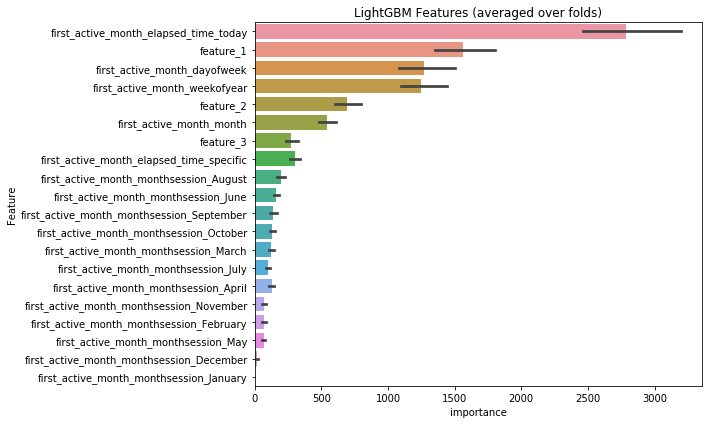

In [23]:
logger.info("Feature importance plot")

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
importances = best_features.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="Feature", data=importances)
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig("importance_20190210.png", dpi=600, quality=100)

In [62]:
importance_grouped = importances.groupby('Feature').agg({"importance": "mean"}).sort_values("importance", ascending=False)
importance_grouped[["first_active_month_" in each_feat for each_feat in importance_grouped.index]].sort_values("importance", ascending=False)

,importance
Feature,
first_active_month_elapsed_time_today,2787.222222
first_active_month_dayofweek,1275.666667
first_active_month_weekofyear,1247.444444
first_active_month_month,545.777778
first_active_month_elapsed_time_specific,301.888889
first_active_month_monthsession_August,198.111111
first_active_month_monthsession_June,162.888889
first_active_month_monthsession_September,142.666667
first_active_month_monthsession_October,133.888889


In [63]:
import gc, sys
gc.collect()
sys._clear_type_cache()

#### analysis between training data and testing data

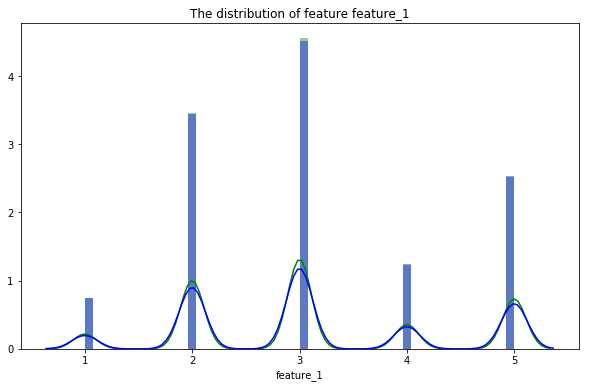

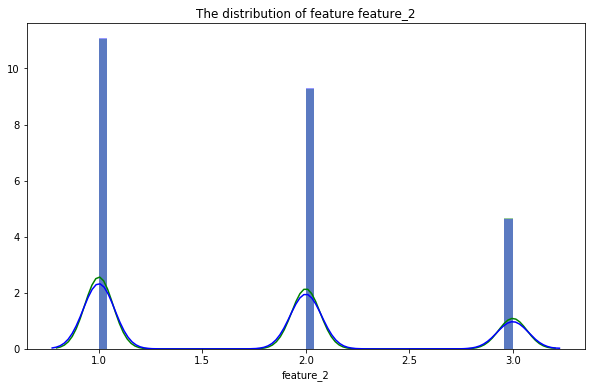

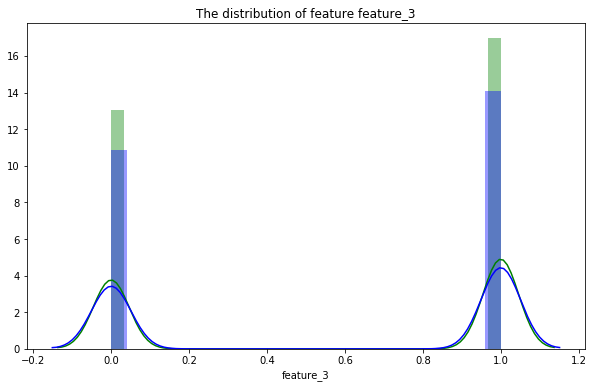

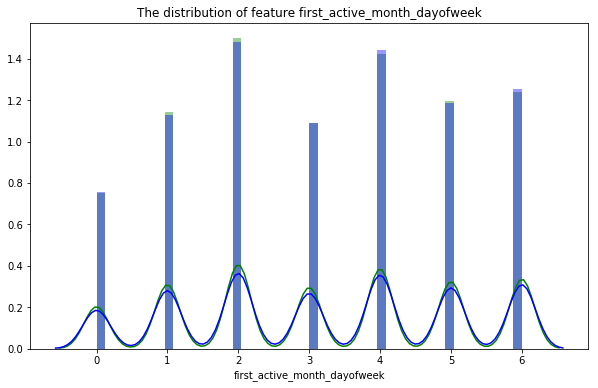

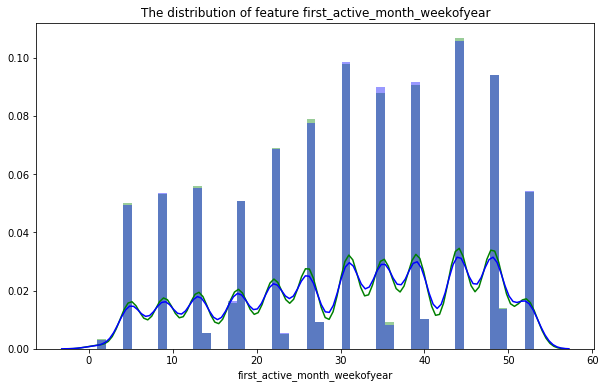

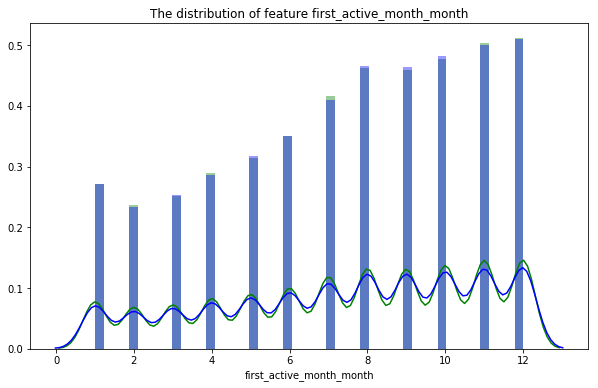

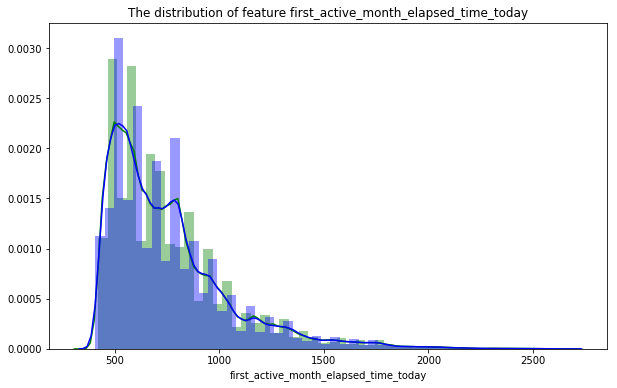

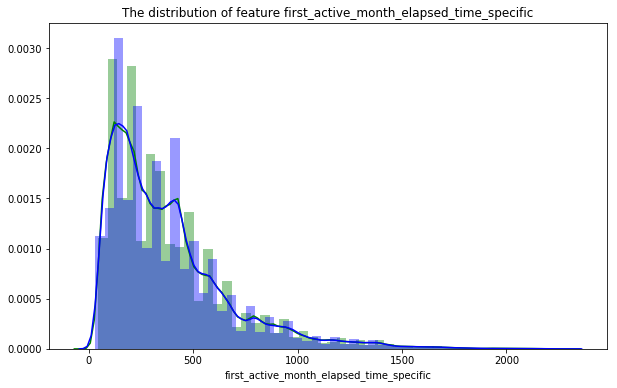

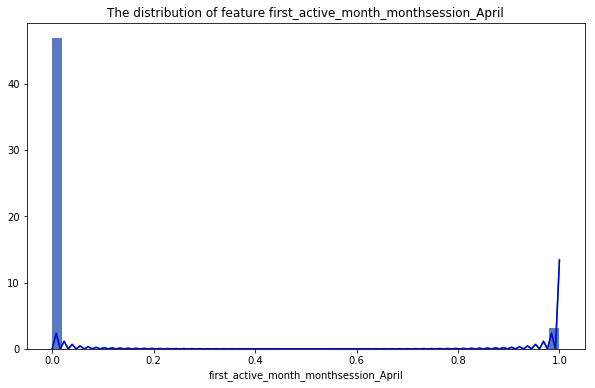

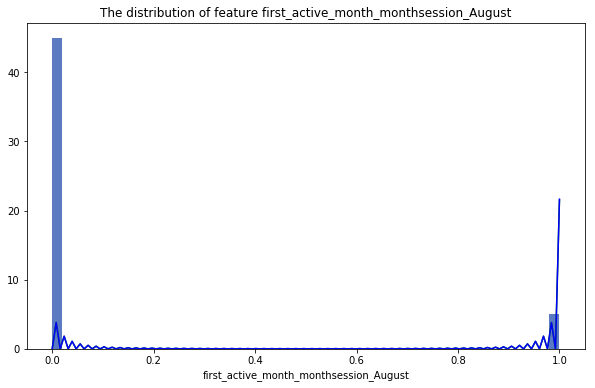

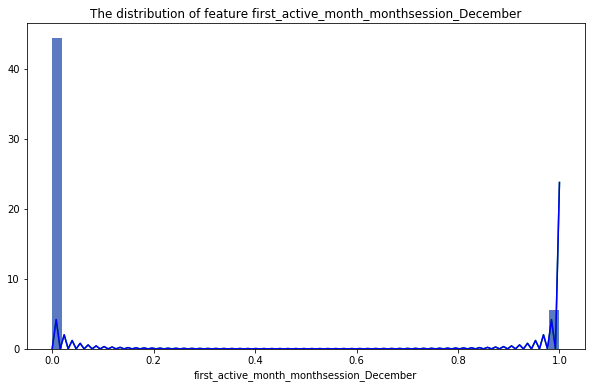

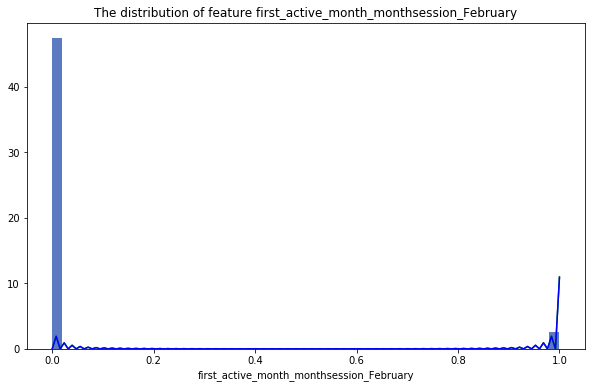

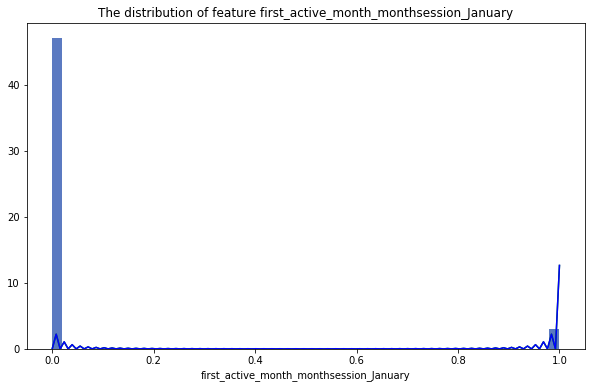

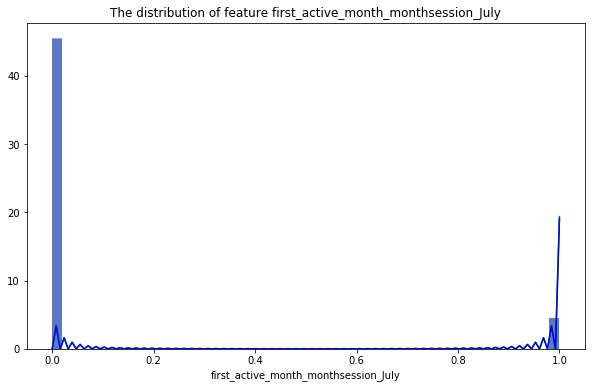

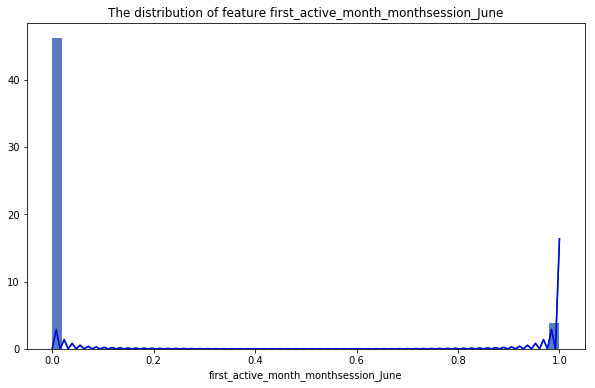

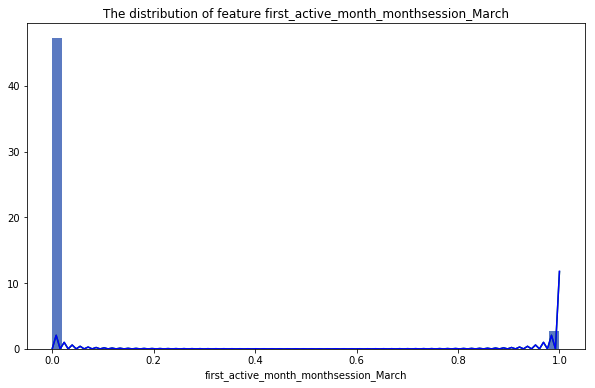

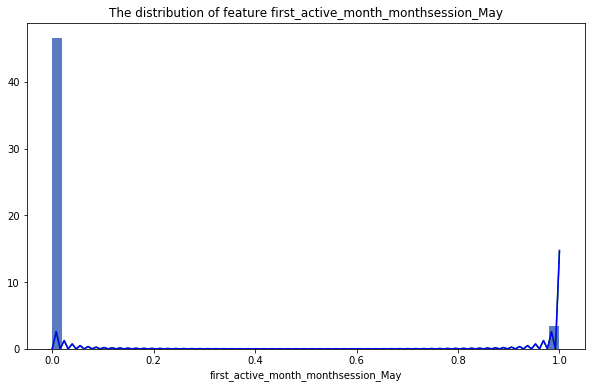

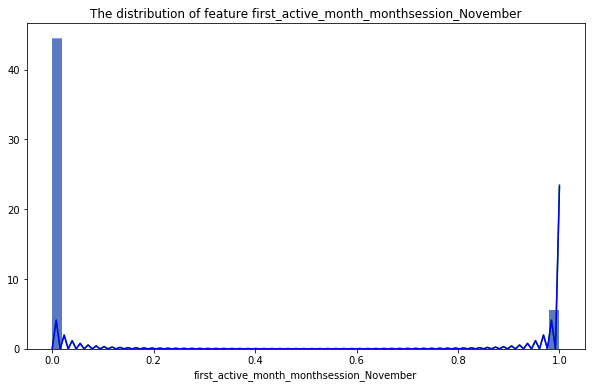

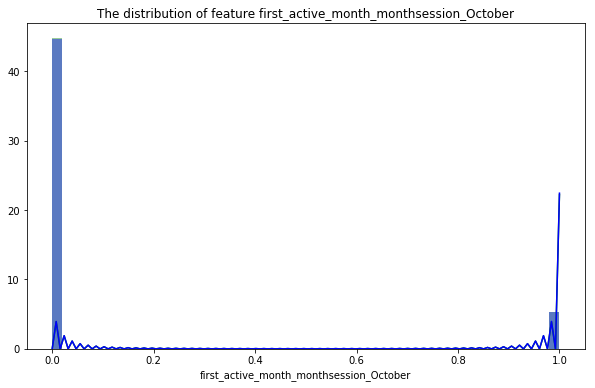

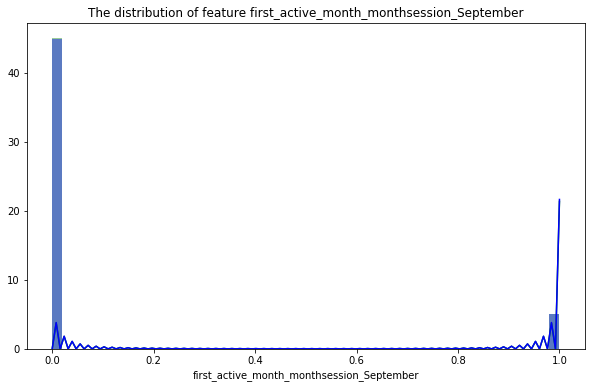

In [40]:
for indent, each_column in enumerate(list(data_test.columns)): 
    fig = plt.figure(num=indent, figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title("The distribution of feature %s" %each_column)
    sns.distplot(data_train[each_column].dropna(), color="g", ax=ax1)
    sns.distplot(data_test[each_column].dropna(), color="b", ax=ax1)

#### conclusion and disscussion

Questions

**1.** According to importance distribution, which column feat contributes most to the model prediction? which column feat contribute least?

**2.** According to importance distribution, by ranging importance of column feat extracted from date data, which extraction wins and which one lose?

**3.** By comparing training dataset and testing dataset, do the column feats found in question2.1 and question 2.2 show different distribution?

**4.** In the next step, to add more feats or to tune the model or change the model? Why?

**5.** If you choose to change the model, why and why not?

Answers:

**1.** "first_active_month_elapsed_time_today" contributes most, while "first_active_month_monthsession_January" contributes least. 

**2.** Among the feat extracted from date data, "first_active_month_elapsed_time_today" gains the most importance while the "first_active_month_monthsession_January" gain the least importance.

**3.** Seeing the "analysis between training data and testing data" part in the notebook, "first_active_month_elapsed_time_today", "first_active_month_elapsed_time_specific" shows measurable different distribution between training data and testing data, among which the first one is the feature picked by the above two questions. On the onther hand, the left feats couldn't provide considerable difference on data distribution between two datasets. 

**4.** In the next step, adding more feats is more preferable. Th reason is that up to now this notebook only use the little obscure feats provided by two datasets. This competition also provides other dataset like transaction records which contains more than 100w data. Meanwhile, now we just use raw data with little data engineering work to obtain a baseline score for later comparison.

**5.** By checking the Lightgbm github [blog](https://github.com/Microsoft/LightGBM), it is learned that this model is truly suitable for this prediction task mainly because of its optimization in speed and optimal split for categorical features which is really helpful for dealing with dataset with more useful information containing in categorical features.